# Multi Target Enviornment

In [858]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Libraries

In [885]:
from utils.riskenv import RiskManagementEnvMultiTarget
from utils.duelingdqn import DuelingDQNPolicy
from utils.common import (create_logger, get_dataset, predict_from_env, 
                          predict_from_frame, running_mean_last_n_samples, 
                          running_mean_per_class, plot_running_means_with_palette)
from utils.networks import ConvNetwork, FCNetwork, LSTMNetwork, GRUNetwork, GRUNetworkBidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import TRPO, RecurrentPPO, QRDQN
from sklearn.preprocessing import MinMaxScaler, Normalizer
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sklearn.metrics import (f1_score, recall_score, precision_score,
                            accuracy_score, mean_squared_error, 
                            r2_score, balanced_accuracy_score)
import warnings
warnings.filterwarnings("ignore")


# Dataset

In [860]:
SEED=123

In [861]:
fpath = "../data/dataset_2/raw/train.csv"
df = pd.read_csv(fpath)
df_copy = df.copy()

In [862]:
# group labels or leave as is
df_copy["Credit_Score"] = df_copy["Credit_Score"].map({"Good": 0, "Standard":1, "Poor": 2})

In [863]:
for column in df_copy.columns:
    # Check if the column is of object type (categorical)
    if df_copy[column].dtype == 'object':
        # Encode the column values to numeric
        df_copy[column] = pd.factorize(df_copy[column])[0]

In [864]:
# show all NaN columns
dropcols = df_copy.isna().sum()[(df_copy.isna().sum() != 0)].index.tolist()
dropcols

['Monthly_Inhand_Salary', 'Num_Credit_Inquiries']

In [865]:
unique_clients = df_copy["Customer_ID"].unique()
default_col = "Credit_Score"
original_features = ['Age',
            'Occupation',
            'Annual_Income', 
            'Num_Bank_Accounts',
            'Num_Credit_Card', 
            'Interest_Rate', 
            'Num_of_Loan', 
            'Type_of_Loan',
       'Delay_from_due_date', 
       'Num_of_Delayed_Payment', 
       'Credit_Mix', 
       'Outstanding_Debt',
       'Credit_Utilization_Ratio', 
       'Credit_History_Age',
       'Payment_of_Min_Amount', 
       'Total_EMI_per_month',
       'Amount_invested_monthly', 
       'Payment_Behaviour', 
       'Monthly_Balance']

In [866]:
CUTOFF = 6 # out of time set
train = df_copy[df_copy["Month"] <= CUTOFF].copy()
test = df_copy[df_copy["Month"] > CUTOFF].copy()

In [867]:
SCALE = False
if SCALE:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train[features] = scaler.fit_transform(train[features])
    train[features] = train[features].clip(-1, 1)
    test[features] = scaler.transform(test[features])
    test[features] = test[features].clip(-1, 1)

In [868]:
train[default_col].value_counts()

Credit_Score
1    46689
2    25396
0    15415
Name: count, dtype: int64

In [869]:
train = train.sort_values(["Month", "Customer_ID"])
test = test.sort_values(["Month", "Customer_ID"])

In [870]:
train.set_index(["Month", "Customer_ID"], inplace=True)
test.set_index(["Month", "Customer_ID"], inplace=True)


In [871]:
train.drop(["ID", "Name", "SSN"], axis=1, inplace=True)
test.drop(["ID", "Name", "SSN"], axis=1, inplace=True)

In [872]:
train_subset = train.copy()

Credit_Score
1    1991
0    1547
2    1530
Name: count, dtype: int64
Credit_Score
1    0.392857
0    0.305249
2    0.301894
Name: proportion, dtype: float64
(5068, 23) 740 724


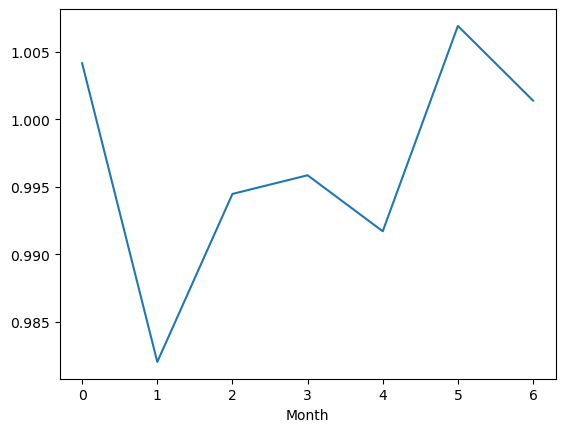

In [873]:
traindummy = train.reset_index()
dmy = []
for i in traindummy.Month.unique():
    a = traindummy[traindummy.Month == i].copy()
    b, c, d, e, f, g, h =  [], [], [] , [], [], [], []
    if i <=2:
        f = a[a[default_col] == 0].sample(40*2)["Customer_ID"].tolist()
        g = a[(a[default_col] == 2)].sample(20*2)["Customer_ID"].tolist()   
    if i > 2 and i <=4:
        b = a[a[default_col] == 1].sample(15*2)["Customer_ID"].tolist()
        c = a[a[default_col] == 0].sample(5*2)["Customer_ID"].tolist()
    if i > 3:
        d = a[a[default_col] == 2].sample(20*2)["Customer_ID"].tolist()
        e = a[a[default_col] == 1].sample(30*2)["Customer_ID"].tolist()

    dmy.append(b+c+d+e+f+g)
# dmy = [traindummy.sample(250).Customer_ID.tolist()]

# flatten list res
flat_list = [item for sublist in dmy for item in sublist]

train_subset = traindummy[traindummy["Customer_ID"].isin(flat_list)]
train_subset["Customer_ID"] = train_subset["Customer_ID"].replace(dict(zip(train_subset["Customer_ID"].unique(), 
                                                                         range(len(train_subset["Customer_ID"].unique())))))
train_subset.groupby('Month')[default_col].mean().plot()
train_subset = train_subset.set_index(["Month", "Customer_ID"])
print(train_subset[default_col].value_counts())
print(train_subset[default_col].value_counts(normalize=True))

print(train_subset.shape, len(flat_list), len(set(flat_list)))

In [874]:
FEATURE_EXPANSION = False
if FEATURE_EXPANSION:
    n_components = 200
    rbf_feature = RBFSampler(gamma=1, n_components=n_components,random_state=SEED)
    features = [f"x_{x}" for x in range(n_components)]
    train_transformed = pd.DataFrame(rbf_feature.fit_transform(train_subset[original_features]), columns=features)
    train_subset = train_subset[[default_col]].reset_index().merge(train_transformed, left_index=True, right_index=True)
    train_subset = train_subset.set_index(["Month", "Customer_ID"])


In [875]:
SCALE = True
if SCALE:
    scaler = MinMaxScaler((-1, 1))
    train_subset[original_features] = scaler.fit_transform(train_subset[original_features])
    train_subset[original_features] = train_subset[original_features].clip(-1, 1)

# Check Environment

In [878]:
LEARNING_STEPS = len(train_subset)
print(LEARNING_STEPS)
CustomEnv = RiskManagementEnvMultiTarget
# Define environment configuration
kwargs = {
    'features_col': original_features, # feature colums
    'default_col': default_col, # default column
    'obs_dim': len(original_features),
    'action_dim' : 3, 
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}


check_env(CustomEnv(train_subset, debug=True, scaled_features=SCALE, accepts_discrete_action=True, seed=SEED, **kwargs), warn=True)

5068
reward: 0.00000 - Client: 429 -Action: 1 - Default: 2.0 - client:   0
reward: -0.50000 - Client: 159 -Action: 2 - Default: 0.0 - client:   1
reward: -0.50000 - Client: 133 -Action: 2 - Default: 1.0 - client:   3
reward: -0.50000 - Client: 127 -Action: 2 - Default: 1.0 - client:   5
reward: 0.00000 - Client: 326 -Action: 1 - Default: 0.0 - client:   0
reward: 0.50000 - Client: 325 -Action: 1 - Default: 1.0 - client:   2


# DQN

In [881]:
kwargs = {
    'features_col': original_features, # feature colums
    'default_col': default_col, # default column
    'obs_dim': len(original_features),
    'action_dim' : 3, 
    'client_dim': len(train_subset.loc[0].index.unique()), # number of clients
    'model_name': "test"
}
num_envs = 1
env_fns = [lambda : CustomEnv(train_subset, debug=True, scaled_features=SCALE, accepts_discrete_action=True, **kwargs) for i in range(num_envs)]
training_env = DummyVecEnv(env_fns)

In [ ]:
feature_extractor = GRUNetwork
# Now use the custom network in policy_kwargs
policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    features_extractor_kwargs=dict(first_layer=400,
                                   first_layer_dropout=0.3,
                                   output_layer=400,
                                   output_layer_dropout=0.1)
)


model_dueling_dqn = DQN(DuelingDQNPolicy, 
                training_env, 
                verbose=1, 
                device="cpu",
                seed=SEED,
                learning_rate=1e-3, 
                gamma=0.9, 
                policy_kwargs=policy_kwargs,
                buffer_size=1_000_000, 
                learning_starts=100, 
                batch_size=64, 
                tau=0.8, 
                train_freq=2
                )
model_dueling_dqn.set_logger(logger)
model_dueling_dqn.learn(LEARNING_STEPS*2,log_interval=1)
model_dueling_dqn.save("../output/multiclass/dqn")

In [ ]:
# Define environment configuration
n_steps = len(train_subset)
rew_dqn, act_dqn = predict_from_env(model_dueling_dqn, training_env, n_steps)
act_dqn_b, date_codes = predict_from_frame(model_dueling_dqn, train_subset[original_features])

Text(0.5, 1.0, 'RMSE : 0.0173 - R2 : -3.9259')

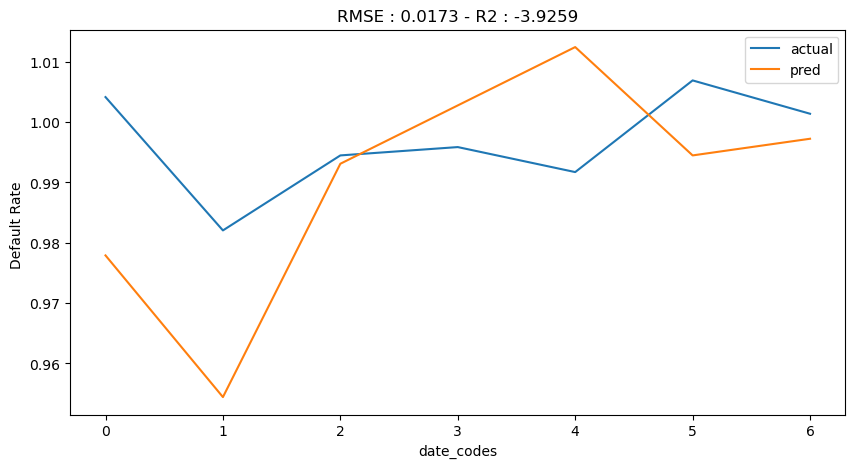

In [915]:
default_preds = pd.DataFrame({"date_codes":date_codes,
              "actual":train_subset[default_col].replace({0:1, 1:0}),
            #   "pred":act_dqn,
              "pred":act_dqn_b
              })
              
res = default_preds.groupby("date_codes").mean()

ax = res.plot(figsize=(10, 5))
# set title for the plot
plt.ylabel("Default Rate ")
ax.set_title(f"RMSE : {np.sqrt(mean_squared_error(res.actual, res.pred)):.4f} - R2 : {r2_score(res.actual, res.pred):1.4f}")

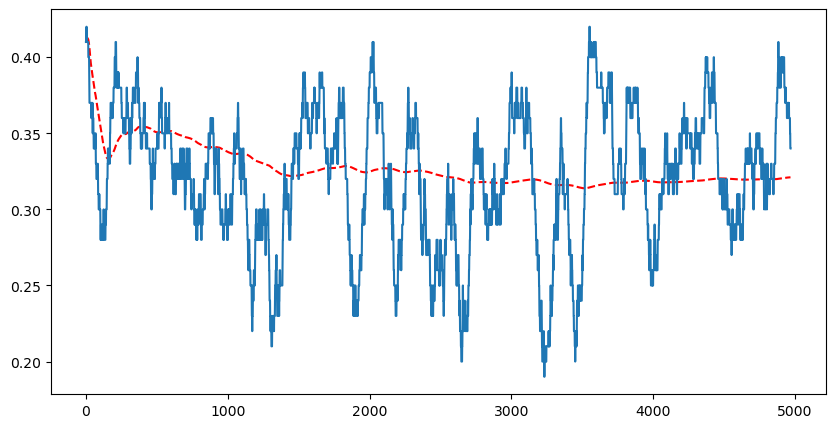

In [903]:
run_mean_rew_dqn = running_mean_last_n_samples(rew_dqn, 100)
plt.figure(figsize=(10, 5))
plt.plot((np.cumsum(run_mean_rew_dqn)/np.arange(1, len(run_mean_rew_dqn)+1)) , color="red", linestyle="dashed")
plt.plot(run_mean_rew_dqn)

In [911]:
# [True Negative ,False Negative]
# [​False Positive, True Positive]
print("-"*30)
print(pd.DataFrame(confusion_matrix(train_subset[default_col].values, act_dqn_b), columns=["0", "1", "2"], index=["0", "1", "2"]))
print("-"*30)
print(classification_report(train_subset[default_col].values, act_dqn_b))



------------------------------
      0     1     2
0  1365   125    57
1   197  1544   250
2    72   180  1278
------------------------------
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1547
           1       0.84      0.78      0.80      1991
           2       0.81      0.84      0.82      1530

    accuracy                           0.83      5068
   macro avg       0.83      0.83      0.83      5068
weighted avg       0.83      0.83      0.83      5068



In [958]:
class0_vs_all = pd.DataFrame({"date_codes":date_codes,
              "actual":train_subset[default_col].replace({0:1, 1:0, 2:0}).values.flatten(),
              "pred":pd.Series(act_dqn_b, name="pred").to_frame().replace({0:1, 1:0, 2:0}).values.flatten(),
              }).groupby("date_codes").mean()


class1_vs_all = pd.DataFrame({"date_codes":date_codes,
              "actual":train_subset[default_col].replace({1:1, 2:0, 0:1}).values.flatten(),
              "pred":pd.Series(act_dqn_b, name="pred").to_frame().replace({1:1, 2:0, 0:1}).values.flatten(),
              }).groupby("date_codes").mean()


class2_vs_all = pd.DataFrame({"date_codes":date_codes,
              "actual":train_subset[default_col].replace({2:1, 1:0, 0:0}).values.flatten(),
              "pred":pd.Series(act_dqn_b, name="pred").to_frame().replace({2:1, 1:0, 0:0}).values.flatten(),
              }).groupby("date_codes").mean()

0.07171581769436941

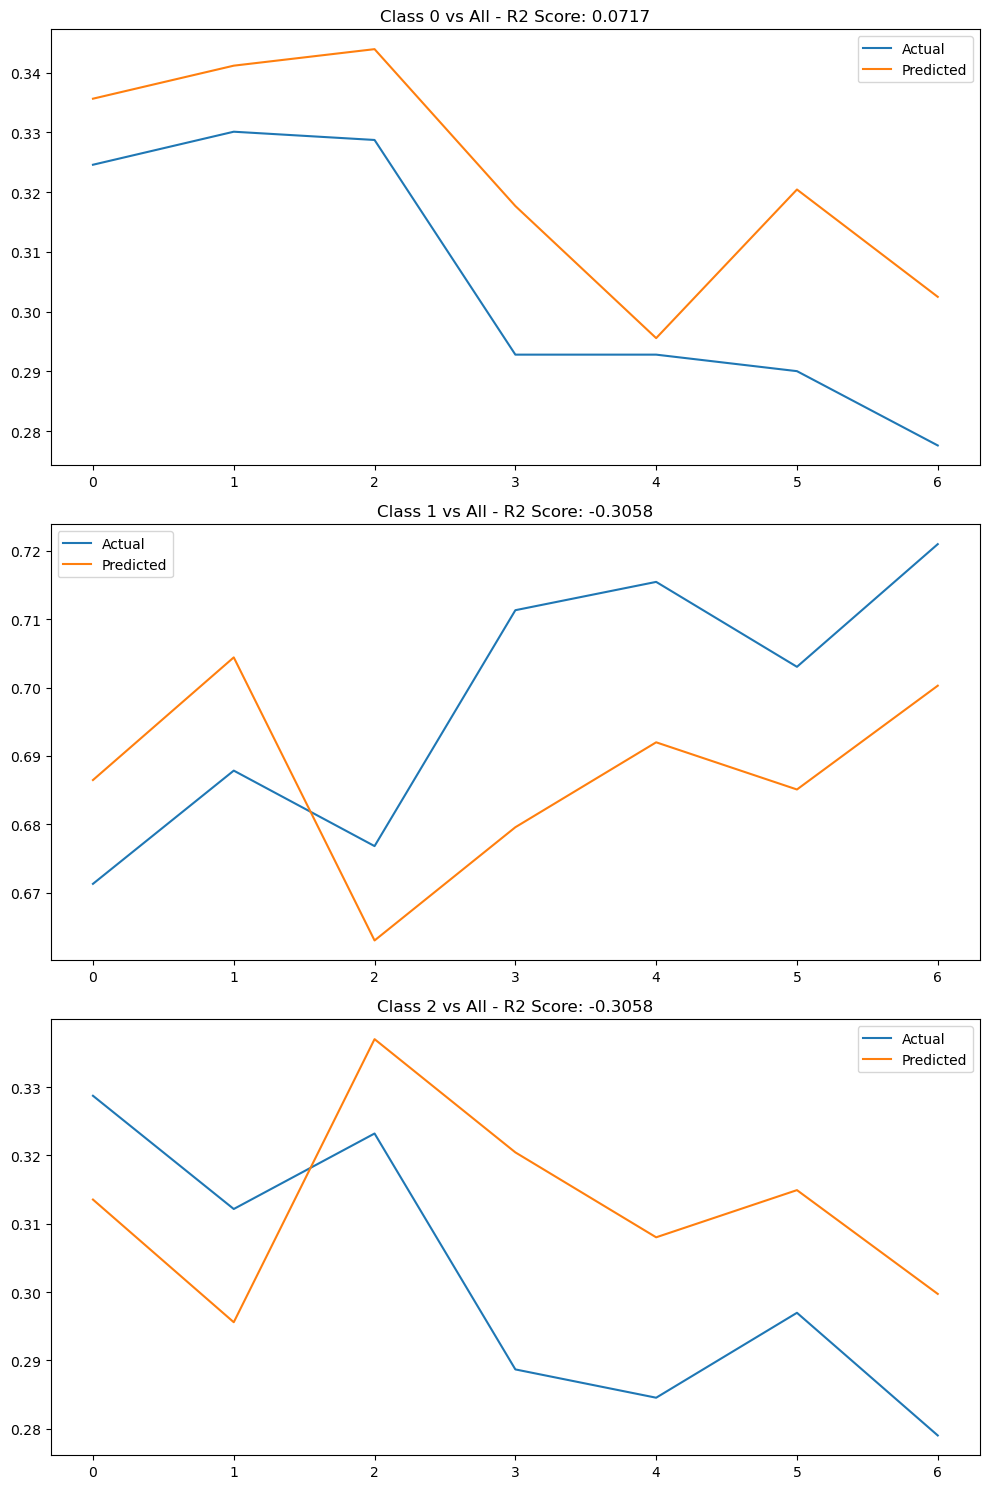

In [967]:
# Calculate r2_scores
r2_score_class0 = r2_score(class0_vs_all['actual'], class0_vs_all['pred'])
r2_score_class1 = r2_score(class1_vs_all['actual'], class1_vs_all['pred'])
r2_score_class2 = r2_score(class2_vs_all['actual'], class2_vs_all['pred'])

# Set up a 3x1 grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # Adjust the size as needed

# Plot class 0 vs all on the first subplot
axs[0].plot(class0_vs_all.index, class0_vs_all['actual'], label='Actual')
axs[0].plot(class0_vs_all.index, class0_vs_all['pred'], label='Predicted')
axs[0].set_title(f'Class 0 vs All - R2 Score: {r2_score_class0:.4f}')
axs[0].legend()

# Plot class 1 vs all on the second subplot
axs[1].plot(class1_vs_all.index, class1_vs_all['actual'], label='Actual')
axs[1].plot(class1_vs_all.index, class1_vs_all['pred'], label='Predicted')
axs[1].set_title(f'Class 1 vs All - R2 Score: {r2_score_class1:.4f}')
axs[1].legend()

# Plot class 2 vs all on the third subplot
axs[2].plot(class2_vs_all.index, class2_vs_all['actual'], label='Actual')
axs[2].plot(class2_vs_all.index, class2_vs_all['pred'], label='Predicted')
axs[2].set_title(f'Class 2 vs All - R2 Score: {r2_score_class2:.4f}')
axs[2].legend()

# Adjust the layout
plt.tight_layout()
plt.savefig("../imgs/3_modeling/one-vs-all.png", bbox_inches='tight')
plt.show()

# Gradient Boosting (Baseline)

In [913]:
model_gb = HistGradientBoostingClassifier()
model_gb.fit(train_subset[original_features], train_subset[default_col])
act_gb = model_gb.predict(train_subset[original_features])
print(classification_report(train_subset[default_col], act_gb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1547
           1       0.99      0.96      0.98      1991
           2       0.98      0.99      0.99      1530

    accuracy                           0.98      5068
   macro avg       0.98      0.98      0.98      5068
weighted avg       0.98      0.98      0.98      5068

